# 03_分子过滤：不需要的子结构
## 本次的目的
- 有一些子结构我们宁愿不包括在我们的筛选库中。在这本次教程中，我们学习了这些不需要的子结构的不同类型，以及如何使用RDKit来发现、突出和移除它们。
## 理论内容
- 不需要的子结构
- Pan assay干扰化合物( PAINS )

## 实践中的内容
- 数据的加载和可视化
- 对 PAINS 进行过滤
- 对不需要的子结构进行过滤
- 突出子结构
- 子结构统计

## 理论
### 不需要的子结构 
- 子结构可能是不利的，例如，由于它们是有毒的或反应性的，由于不利的药代动力学性质，或者因为它们可能干扰某些测定。如今，药物发现活动往往涉及高通量筛选。过滤不需要的子结构可以支持组装更高效的筛选库，从而可以节省时间和资源。
- 文献已经组装了一系列不利的子结构，以筛选用于治疗被忽视疾病的化合物库。这些不需要的特征的例子是硝基(mutagenic)，硫酸盐和磷酸盐(likely resulting in unfavorable pharmacokinetic properties)，2-halopyridines(reactive)。

## Pan assay interference compound ( PAINS ) 
- PAINS是HTS中经常作为hits出现的化合物，尽管它们实际上是假阳性。PAINS在许多靶点而不是一个特定的靶点显示活性。这种行为是由于非特异性结合或与分析成分相互作用的结果。重点关注干扰分析信号的亚结构。他们描述了有助于识别此类PAINS的子结构，并提供了可用于子结构筛选的列表。

## 实战
- 对数据进行加载和可视化
- 首先，我们导入所需的库，从 02 中加载我们筛选的数据集，并画出第一个分子。

## 02 中的 保存过滤后的数据
- molecules_ro5_fulfilled.to_csv(DATA / "compounds_lipinski.csv")
- 我们需要compounds_lipinski.csv这个数据，放在data中

In [47]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [48]:
from pathlib import Path
import os

# 获取当前工作目录
HERE = Path(os.getcwd())
DATA = HERE / 'data'
if not DATA.exists():
    DATA.mkdir(parents=True, exist_ok=True)
print(DATA)


/Users/wangyang/Desktop/AI-drug-design/list/03_Molecular_filtration_of_unwanted_substructures/data


In [49]:
# load data from  T2
# 不能加index_col=0, 否则会把第一列当做index
asthma_data = pd.read_csv(
    DATA / "./compounds_lipinski.csv",
)
# 丢弃不必要的信息
print("Dataframe shape:", asthma_data.shape)
asthma_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
asthma_data.head()

Dataframe shape: (201, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled
0,CHEMBL388978,0.298,nM,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,9.525784,True
1,CHEMBL4635883,8.000,nM,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,8.096910,True
2,CHEMBL4633229,22.000,nM,CC(C)(C#N)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=...,7.657577,True
3,CHEMBL4640712,26.000,nM,CC(C)(C#N)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=...,7.585027,True
4,CHEMBL4632457,27.000,nM,CC(C)(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)...,7.568636,True


In [50]:
print(asthma_data.columns)


Index(['molecule_chembl_id', 'IC50', 'units', 'smiles', 'pIC50',
       'ro5_fulfilled'],
      dtype='object')


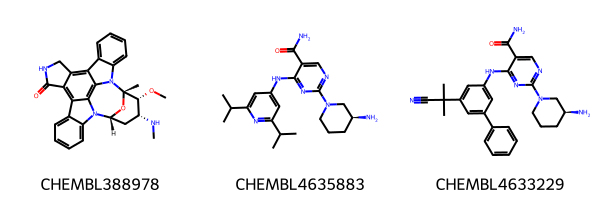

In [51]:
# 根据smile字符串把化合物结构信息添加到dataframe中
PandasTools.AddMoleculeColumnToFrame(asthma_data, smilesCol='smiles')
# 画出前三个化合物
Chem.Draw.MolsToGridImage(
    list(asthma_data.head(3).ROMol),
    legends=list(asthma_data.head(3).molecule_chembl_id),
)

过滤 PAINS ¶
PAINS 过滤器已在 RDKit 中实现（文档）。可以通过 FilterCatalog 类应用此类预定义过滤器。让我们了解一下如何使用它。

PAINS 是“Pan Assay Interference Compounds”的缩写。这些化合物被认为会在多种生物测定中产生干扰，导致虚假阳性结果。PAINS 化合物具有一些共同的化学特征，使其在药物筛选过程中成为不可靠的候选物。因此，在药物发现和开发过程中，通常需要筛选掉这些 PAINS 化合物，以提高筛选结果的可靠性。

RDKit 中的 PAINS 过滤器
RDKit 提供了一个内置的 PAINS 过滤器，可以用于识别和移除这些干扰化合物。PAINS 过滤器通过 FilterCatalog 类实现。

In [52]:
# 初始化滤波器
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [64]:
# 搜索 PAINS
matches = []
clean = []
for index, row in tqdm(asthma_data.iterrows(), total=asthma_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # 获取第一个匹配的 PAINS
    if entry is not None:
        # 存储 PAINS 信息
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # 收集无 PAINS 分子的指数
        clean.append(index)

matches = pd.DataFrame(matches)
asthma_data = asthma_data.loc[clean]  # 保留无PAINS的分子

  0%|          | 0/199 [00:00<?, ?it/s]

In [65]:

print(f"具有PAINS的化合物数量: {len(matches)}")
print(f"不含PAINS的化合物数目: {len(asthma_data)}")

具有PAINS的化合物数量: 0
不含PAINS的化合物数目: 199


In [66]:
# 保存不含PAINS的化合物
asthma_data.to_csv(DATA / "asthma_data_clean_PAINS.csv", index=False)

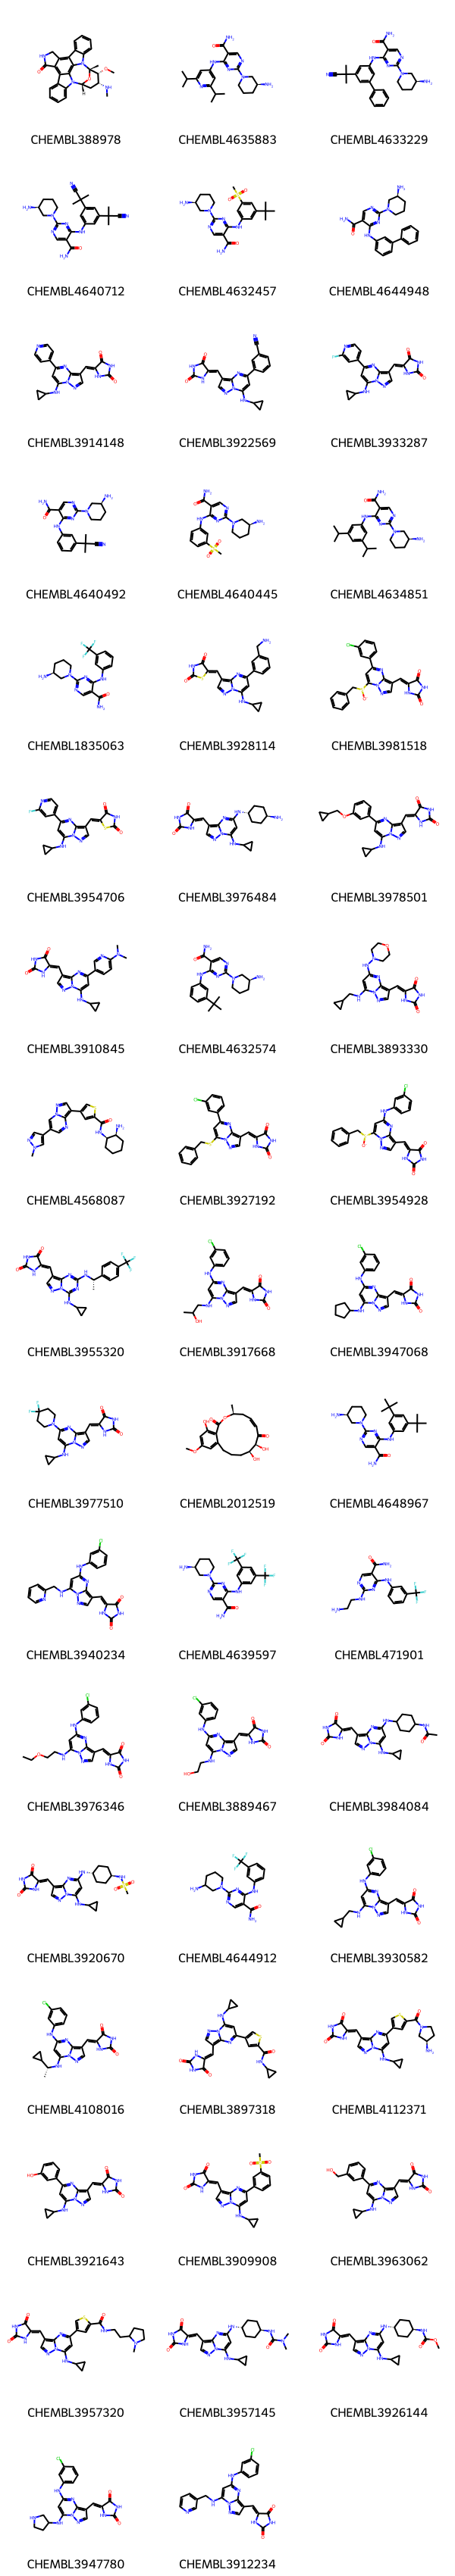

In [67]:
# 画出不含PAINS的化合物
Chem.Draw.MolsToGridImage(
    list(asthma_data.head(50).ROMol),
    legends=list(asthma_data.head(50).molecule_chembl_id),
)

# Chem.Draw.MolsToGridImage(
#     list(matches.head(3).rdkit_molecule),
#     legends=list(matches.head(3)["pains"]),
# )

In [68]:
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    legends=list(matches.head(3)["pains"]),
)

AttributeError: 'DataFrame' object has no attribute 'rdkit_molecule'

过滤并突出显示不需要的子结构 ¶
一些不需要的子结构列表（例如 PAINS）已在 RDKit 中实现。但是，也可以使用外部列表并手动获取子结构匹配。在这里，我们使用 Brenk 等人的支持信息中提供的列表。

In [57]:
substructures = pd.read_csv(DATA / "unwanted_substructures.csv", sep="\s+")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("收集到的不需要的子结构数量:", len(substructures))
# NBVAL_CHECK_OUTPUT

FileNotFoundError: [Errno 2] No such file or directory: '/Users/wangyang/Desktop/AI-drug-design/list/03_Molecular_filtration_of_unwanted_substructures/data/unwanted_substructures.csv'

让我们看一下一些子结构。

In [ ]:
Chem.Draw.MolsToGridImage(
    mols=substructures.rdkit_molecule.tolist()[2:5],
    legends=substructures.name.tolist()[2:5],
)

在我们过滤后的数据框中搜索与这些不需要的子结构的匹配项。

In [58]:
# 搜索不需要的子结构
matches = []
clean = []
for index, row in tqdm(asthma_data.iterrows(), total=asthma_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
asthma_data = asthma_data.loc[clean]

  0%|          | 0/199 [00:00<?, ?it/s]

NameError: name 'substructures' is not defined

In [59]:

print(f"发现的不需要的子结构数量: {len(matches)}")
print(f"无杂质子结构的化合物数量: {len(asthma_data)}")

发现的不需要的子结构数量: 0
无杂质子结构的化合物数量: 199


突出显示子结构 ¶
让我们看一下前 3 个已识别出的不需要的子结构。由于我们可以访问底层 SMARTS 模式，因此我们可以突出显示 RDKit 分子内的子结构。

In [60]:
# 保存匹配的需要的子结构
asthma_data.to_csv(DATA / "asthma_data_ubstructures_matches.csv", index=False)

In [61]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(6).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(6).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(6).substructure_name),
)

AttributeError: 'list' object has no attribute 'head'

子结构统计 ¶
最后，我们想要找到数据集中最常见的子结构。 Pandas DataFrame 提供了方便的方法来对包含的数据进行分组并检索组大小。

In [62]:
# NBVAL_CHECK_OUTPUT
groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

AttributeError: 'list' object has no attribute 'groupby'

我们了解了使用 RDKit 搜索不需要的子结构的两种可能性：

FilterCatalog 类可用于搜索预定义的子结构集合，例如 PAINS。

HasSubstructMatch() 函数执行手动子结构搜索。

实际上，PAINS 过滤也可以通过 HasSubstructMatch() 手动子结构搜索来实现。此外，Brenk 等人定义的子结构。 ( Chem. Med. Chem. (2008), 3, 535-44) 已作为 FilterCatalog 实现。其他预定义集合可以在 RDKit 文档中找到。

到目前为止，我们一直在使用 HasSubstructMatch() 函数，它只为每个化合物生成一个匹配项。通过 GetSubstructMatches() 函数（文档），我们有机会识别化合物中特定子结构的所有出现。对于 PAINS，我们只查看每个分子的第一个匹配 ( GetFirstMatch() )。如果我们只是想过滤掉所有的痛苦，这就足够了。然而，我们也可以使用 GetMatches() 来查看分子的所有关键子结构。

检测到的子结构可以用两种不同的方式处理：

或者，将子结构搜索用作过滤器，并将化合物排除在进一步测试之外，以节省时间和金钱。

或者，它们可以用作警告，因为 FDA 批准的药物中约 5% 被发现含有 PAINS。在这种情况下，专家可以手动判断所识别的子结构是否关键。

